In [1]:
import numpy as np
import matplotlib.pyplot as plt
import netCDF4 as nc

import glob
convFiles=glob.glob("convProfs/*nc")
print(convFiles)

ntot=0
zKuL=[]
zKaL=[]
pRateDPRL=[]
pRateCMBL=[]
dmCMBL=[]
nodes2L=[]
bsfcL=[]
piaKuL=[]
piaDPRL=[]
bcfL=[]
n1,n2=1,9
ns=66
for f in convFiles[:]:
    with nc.Dataset(f) as fh:
        hzero=fh['hzero'][:,n1:n2,4]
        zKu=fh['zKu'][:,n1:n2,4]
        zKa=fh['zKa'][:,n1:n2,4]
        bzd=fh['bzd'][:,4,4]
        bcf=fh['bcf'][:,4,4]
        bsfc=fh['elevation'][:,4,4]
        elev=fh['elevation'][:,4,4]
        PIAhyb=fh['PIAhyb'][:,n1:n2,4]
        PIAhybDPR=fh['PIAhybDPR'][:,n1:n2,4]
        bsfc[bsfc<0]=0
        bsfc=(175-(bsfc/125))
        
        precipDPR=fh['precip'][:,n1:n2,4,:]
        precipCMB=fh['precipCMB'][:,n1:n2,4,:]  
        dmCMB=fh['dmCMB'][:,n1:n2,4] 
        n24=30
        a=np.nonzero(bcf-bzd>n24)
        for i in a[0]:            
            nodes=list(range(bzd[i]-ns,bzd[i]+n24))
            if nodes[0]%2==0:
                nodes2=nodes[::2]
            else:
                nodes2=nodes[1::2]
            nodes2=np.array(nodes2)//2         
            if precipCMB[i,:,nodes2[-1]].min()>-0.1:
                zKuL.append(zKu[i,:,bzd[i]-ns:bzd[i]+n24])
                zKaL.append(zKa[i,:,bzd[i]-ns:bzd[i]+n24])
                pRateDPRL.append(precipDPR[i,:,bzd[i]-ns:bzd[i]+n24])
                pRateCMBL.append(precipCMB[i,:,:][:,nodes2])
                dmCMBL.append(dmCMB[i,:,:][:,nodes2])
                piaKuL.append(PIAhyb[i,:])
                piaDPRL.append(PIAhybDPR[i,:,:])
                bsfcL.append(bsfc[i])
                bcfL.append(bcf[i])
                nodes2L.append(nodes2)
                ntot+=1
print(ntot)

['convProfs/convProfs_20200701-02.nc', 'convProfs/convProfs_20200201-05.nc', 'convProfs/convProfs_20200601-02.nc', 'convProfs/convProfs_20200301-05.nc', 'convProfs/convProfs_20200401-02.nc', 'convProfs/convProfs_20200101-05.nc', 'convProfs/convProfs_20200501-02.nc', 'convProfs/convProfs_20200501-05.nc', 'convProfs/convProfs_20200401-05.nc', 'convProfs/convProfs_20200101-02.nc', 'convProfs/convProfs_20200601-05.nc', 'convProfs/convProfs_20200301-02.nc', 'convProfs/convProfs_20200701-05.nc', 'convProfs/convProfs_20200201-02.nc']
48051


48051
(48051, 3, 96, 8)


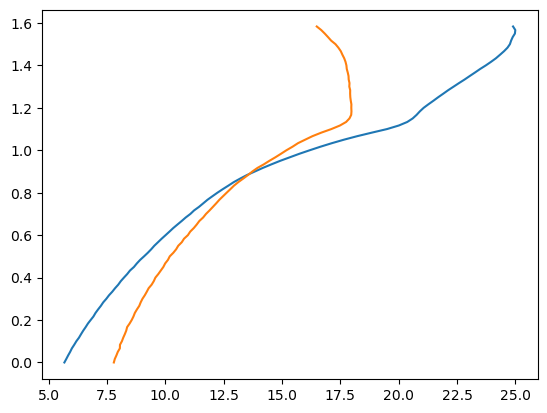

In [16]:
print(len(pRateCMBL))
nt=len(pRateCMBL)
X=np.zeros((nt,8,ns+n24,3),float)
zKuL=np.array(zKuL)
zKaL=np.array(zKaL)
zKuL[zKuL<0]=0
zKaL[zKaL<0]=0
xrange=(np.arange(ns+n24)-60.0)/60.0+1
import matplotlib.pyplot as plt
plt.plot(zKuL.mean(axis=(0,1)),xrange)
plt.plot(zKaL.mean(axis=(0,1)),xrange)
#plt.plot(zKuL[1000,:])
#plt.plot(zKaL[1000,:])
X[:,:,:,0]=zKuL/zKuL.std(axis=(0,1))
X[:,:,:,1]=zKaL/zKuL.std(axis=(0,1))

X=X.swapaxes(1,3)
print(X.shape)
#for k in range(nt):
#    X[k,:,2]=xrange


In [18]:
import torch
from torch.utils.data import DataLoader, TensorDataset
pRateDPRL=np.array(pRateDPRL)
y=np.log(1+pRateDPRL)
print(y.min(),y.max(),y.mean(),y.std())
ymean=y.mean(axis=0)
ystd=y.std(axis=0)
y_scaled=(y-ymean)/ystd
y_scaled=y_scaled[:,:,:,np.newaxis]
y_scaled=y_scaled.swapaxes(1,3)
print(y_scaled.shape)
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y_scaled, test_size=0.2, random_state=42)
# import torch dataset and torch Dataloader

from torch.utils.data import DataLoader, TensorDataset

train_data = TensorDataset(torch.tensor(X_train).float(), torch.tensor(y_train).float())
test_data = TensorDataset(torch.tensor(X_test).float(), torch.tensor(y_test).float())
batch_size = 128
train_loader = DataLoader(train_data, shuffle=True, batch_size=batch_size)

0.0 5.7070107 0.5109118 0.8710348
(48051, 1, 96, 8)


In [21]:
from neuralop.models import TFNO

fno_model = TFNO(n_modes=(16, 2), hidden_channels=32, projection_channels=16, factorization='tucker', rank=0.42,
             in_channels=2, out_channels=1, dropout=0.1, groups=1)

xtest=torch.tensor(np.random.rand(1,2,ns+n24,8).astype(np.float32))

y=fno_model(xtest,output_shape=(ns+n24,16))
print(y.shape)

torch.Size([1, 1, 96, 16])


In [22]:
from torch import nn, optim
criterion_mse=nn.MSELoss(reduction='mean')
optimizer = optim.Adam(fno_model.parameters(), lr=0.001)

In [23]:
n_epochs = 5
for epoch in range(1, n_epochs + 1):
    train_loss = 0.0
    ibatch=0
    for data, target in train_loader:
        optimizer.zero_grad()
        #z, mean, std = bayesian_lstm(data[:,:,0:2])
        z = fno_model(data[:,:2,:,:])
        #print(z.shape)
        #print(target.shape)
        #loss1 = 0.5*criterion(z[:,::8,:,:],target[:,::8,:])
        #print(z.shape)
        #print(target.shape)
        #loss2= 0.5*criterion_mse(z[:,:-1,:,2],target[:,:-1,:])
        #loss=loss1+loss2
        loss=criterion_mse(z,target)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
        ibatch+=1
    train_loss = train_loss / ibatch
    print('Epoch: {} \tTraining Loss: {:.6f}'.format(epoch, train_loss))

Epoch: 1 	Training Loss: 0.220444
Epoch: 2 	Training Loss: 0.125031
Epoch: 3 	Training Loss: 0.110274
Epoch: 4 	Training Loss: 0.103738
Epoch: 5 	Training Loss: 0.097892


In [24]:
y_pred=fno_model(torch.tensor(X_test).float()[:,:2,:,:])


In [30]:
y_pred2=fno_model(torch.tensor(X_test).float()[:,:2,:,:])


In [32]:
y_pred2_numpy=y_pred2.detach().numpy()
y_pred_numpy=y_pred.detach().numpy()
print(y_pred_numpy.shape)
print(y_test.shape)
print(np.corrcoef(y_pred2_numpy[:,0,-1,3],y_test[:,0,-1,3]))
print(np.corrcoef(y_pred2_numpy[:,0,-1,3],y_pred_numpy[:,0,-1,3]))

(9611, 1, 96, 8)
(9611, 1, 96, 8)
[[1.         0.69955493]
 [0.69955493 1.        ]]
[[1. 1.]
 [1. 1.]]
